## Capstone 3 - Rossmann Store Sales Prediction (Time Series Analysis)

Rossmann operates over 3,000 drug stores in 7 European countries. The Objectives of this project is to analyze Rossmann's store profile and sales data, build a model to predict their daily sales for up to six weeks in advance. <br><br>
An accompanying analysis and building a regression model for prediction can be found at this [link](https://github.com/jade-lam/Springboard-DSC-Capstone-3/blob/main/Capstone%203%20-%20Rossmann%20Store%20Sales%20Prediction%20(Regression).ipynb). The focus of this workbook is to examine Rossmann's store sales prediction as a time-series problem.  

In [ ]:
#!pip install Prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.testing as tm
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Loading the Dataset

In [4]:
#url to each dataset
store_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/store.csv'
test_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/test.csv'
train_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/train.csv'

In [5]:
# loading the data 
store = pd.read_csv(store_raw, low_memory=False)
train = pd.read_csv(train_raw, parse_dates=['Date'], low_memory=False)
test = pd.read_csv(test_raw, low_memory=False)

In [6]:
# examining the training dataset
print("length/ features :", train.shape)
train.head(3)

length/ features : (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


##2) Building the Data for Time Series Analysis 

In [7]:
#aggregating sales by date
salbydate = pd.pivot_table(train,index=['Date'],values=['Sales'],aggfunc=sum).reset_index()
salbydate = salbydate.rename(columns={'Date': 'ds', 'Sales': 'y'})
salbydate.head()

,ds,y
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


In [8]:
#date range of the dataset
print('date range of the dataset:', salbydate['ds'].min(), 'to', salbydate['ds'].max())

date range of the dataset: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


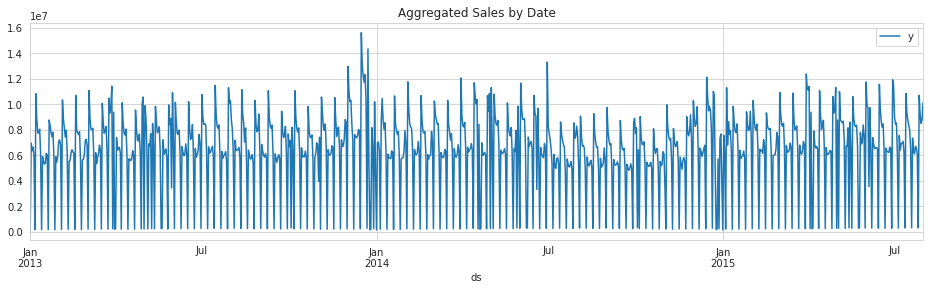

In [9]:
salbydate.plot(x='ds', y='y', title='Aggregated Sales by Date', figsize=[16, 4])

##3) Pre-Processing

In [10]:
# getting the train/test split (75/25)
test_length = 705
df_train = salbydate.iloc[0:test_length]
df_test = salbydate.iloc[test_length:-1]

In [11]:
df_train.shape, df_test.shape

((705, 2), (236, 2))

In [12]:
#start/end dates of the training & testing sets
print('date range of the traiing data:', df_train['ds'].min(), 'to', df_train['ds'].max())
print('date range of the testing data:', df_test['ds'].min(), 'to', df_test['ds'].max())

date range of the traiing data: 2013-01-01 00:00:00 to 2014-12-06 00:00:00
date range of the testing data: 2014-12-07 00:00:00 to 2015-07-30 00:00:00


##4) Modelling

4.1) Prophet Model

In [13]:
p = Prophet(daily_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
p_model = p.fit(df_train)

In [14]:
future_p_df = p.make_future_dataframe(periods=236, freq='D')
forecast = p.predict(future_p_df)

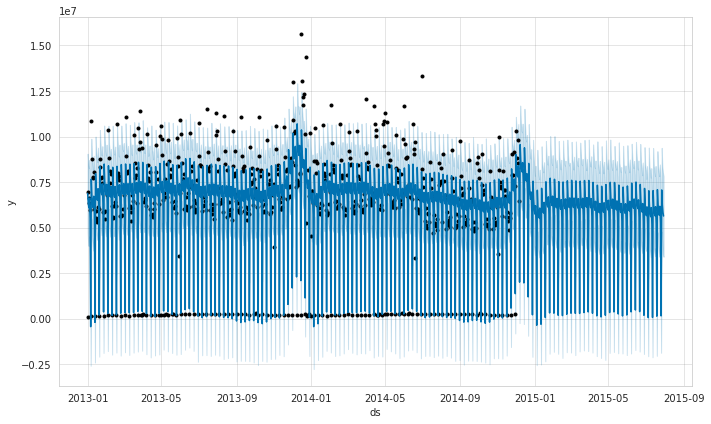

In [15]:
forecast_fig = p.plot(forecast)

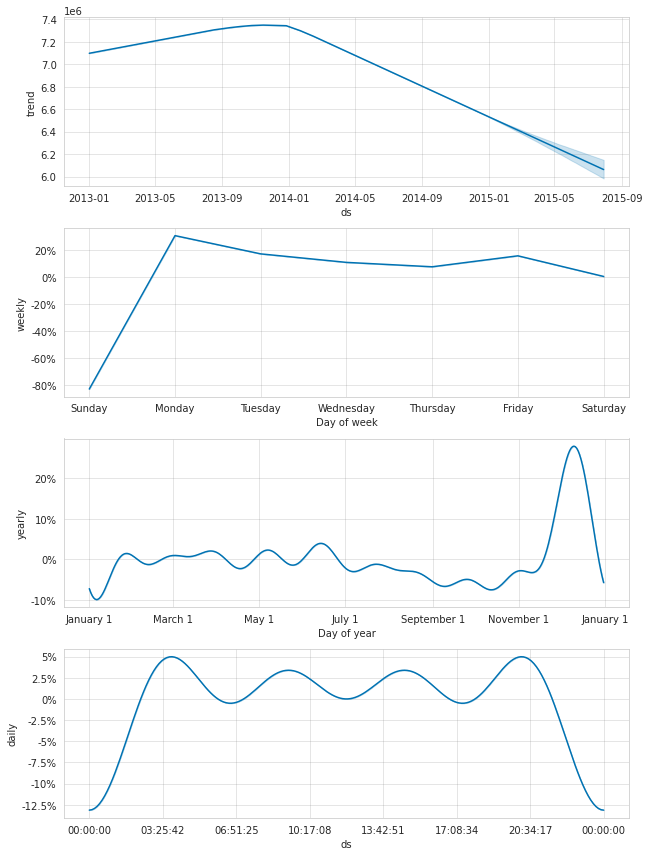

In [16]:
components_fig = p.plot_components(forecast)

In [17]:
#seeing the actual price prediction
future_preds = forecast.loc[forecast['ds'] > '2014-12-05']
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
future_preds.head(5)

,ds,yhat,yhat_lower,yhat_upper
704,2014-12-06,"7,459,348.51","5,302,062.56","9,705,520.95"
705,2014-12-07,"2,000,857.21","-249,079.10","4,076,734.77"
706,2014-12-08,"9,556,576.59","7,382,798.83","11,700,902.24"
707,2014-12-09,"8,688,024.02","6,318,130.74","10,751,418.41"
708,2014-12-10,"8,280,709.42","6,092,895.13","10,343,410.89"


4.2) Cross Valiation 

In [18]:
#cross validation
p_cv = cross_validation(p, initial='614 days', period='90 days', horizon = '90 days')
df_p = performance_metrics(p_cv)
df_p

INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-09-07 00:00:00 and 2014-09-07 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,"2,020,244,333,943.25","1,421,352.99","1,181,066.27",0.26,0.30,0.89
1,10 days,"1,344,954,127,102.53","1,159,721.57","944,839.27",0.21,0.23,1.00
2,11 days,"928,623,760,825.36","963,651.27","750,132.18",0.18,0.19,1.00
3,12 days,"716,117,049,290.41","846,236.99","657,453.74",0.15,0.11,1.00
4,13 days,"725,134,903,234.18","851,548.53","661,093.31",0.16,0.11,1.00
...,...,...,...,...,...,...,...
77,86 days,"320,459,605,029.22","566,091.52","396,756.71",0.61,0.02,1.00
78,87 days,"323,026,451,659.91","568,354.16","402,499.78",0.61,0.03,1.00
79,88 days,"328,110,338,295.42","572,809.16","416,893.73",0.61,0.03,1.00
80,89 days,"383,037,852,395.90","618,900.52","480,570.97",0.61,0.05,1.00


In [19]:
print('Avg RMSE score:', round(df_p['rmse'].mean(), 3))
print('Avg MAPE score:', round(df_p['mape'].mean(), 3))

Avg RMSE score: 1276673.551
Avg MAPE score: 0.566


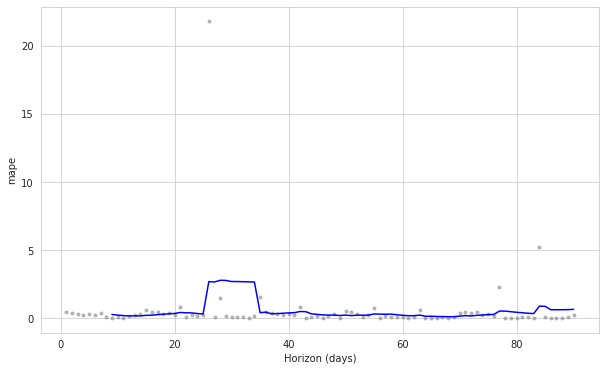

In [20]:
p_cv_metrics = plot_cross_validation_metric(p_cv, metric='mape')

##5) Model Evaluation & Optimization

5.1) Hyperparameters Tuning

In [21]:
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.5, 5],
    'seasonality_prior_scale': [0.1, 1.0, 5],
    'holidays_prior_scale':[0.1, 1, 5],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [22]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv1 = cross_validation(m, period='90 days', horizon='90 days', parallel="processes")
    df_p1 = performance_metrics(df_cv1, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2013-12-11 00:00:00 and 2014-09-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1643d81190>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2013-12-11 00:00:00 and 2014-09-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f163c9fee50>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

    changepoint_prior_scale  ...         rmse
0                      0.10  ... 1,421,352.99
1                      0.10  ... 1,421,352.99
2                      0.10  ... 1,421,352.99
3                      0.10  ... 1,421,352.99
4                      0.10  ... 1,421,352.99
5                      0.10  ... 1,421,352.99
6                      0.10  ... 1,421,352.99
7                      0.10  ... 1,421,352.99
8                      0.10  ... 1,421,352.99
9                      0.50  ... 1,421,352.99
10                     0.50  ... 1,421,352.99
11                     0.50  ... 1,421,352.99
12                     0.50  ... 1,421,352.99
13                     0.50  ... 1,421,352.99
14                     0.50  ... 1,421,352.99
15                     0.50  ... 1,421,352.99
16                     0.50  ... 1,421,352.99
17                     0.50  ... 1,421,352.99
18                     5.00  ... 1,421,352.99
19                     5.00  ... 1,421,352.99
20                     5.00  ... 1

In [23]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1}


5.2) Re-running the Model with Optimized Parameters & Removing Outliers

In [24]:
p1 = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale= 0.1, holidays_prior_scale= 0.1, 
             daily_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative', interval_width=0.9)
p1_model = p1.fit(df_train)

In [25]:
future_p1_df = p1.make_future_dataframe(periods=236, freq='D')
forecast1 = p1.predict(future_p1_df)

In [26]:
#cross validation
p1_cv = cross_validation(p1, initial='614 days', period='90 days', horizon = '90 days')
df_p1 = performance_metrics(p1_cv)
df_p1

INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-09-07 00:00:00 and 2014-09-07 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,"1,615,175,220,321.06","1,270,895.44","1,076,682.77",0.25,0.26,1.00
1,10 days,"1,045,224,634,160.47","1,022,362.28","836,592.59",0.21,0.19,1.00
2,11 days,"709,141,993,859.56","842,105.69","650,249.75",0.17,0.15,1.00
3,12 days,"526,186,089,976.30","725,386.86","549,075.81",0.15,0.09,1.00
4,13 days,"523,075,683,894.68","723,239.71","547,538.36",0.15,0.09,1.00
...,...,...,...,...,...,...,...
77,86 days,"587,154,547,682.66","766,260.10","668,277.50",0.58,0.07,1.00
78,87 days,"550,715,921,600.67","742,102.37","621,127.98",0.58,0.05,1.00
79,88 days,"591,663,529,068.06","769,196.68","665,780.25",0.58,0.08,1.00
80,89 days,"738,218,055,403.62","859,196.17","771,419.02",0.59,0.09,1.00


In [27]:
print('Avg RMSE score:', round(df_p1['rmse'].mean(), 3))
print('Avg MAPE score:', round(df_p1['mape'].mean(), 3))

Avg RMSE score: 1192365.285
Avg MAPE score: 0.564


5.3) Devitions against Original Data

In [106]:
#seeing the actual price prediction
future_preds1 = forecast1.loc[forecast['ds'] > '2014-12-05']
future_preds1 = future_preds1[['ds','yhat','yhat_lower','yhat_upper']]
future_preds1.head()

,ds,yhat,yhat_lower,yhat_upper
704,2014-12-06,"7,461,034.66","4,650,491.19","10,239,187.35"
705,2014-12-07,"2,032,077.18","-693,328.50","4,882,840.60"
706,2014-12-08,"9,549,886.19","6,727,295.26","12,310,886.36"
707,2014-12-09,"8,687,453.99","5,805,550.97","11,399,528.68"
708,2014-12-10,"8,283,779.89","5,301,224.21","10,925,674.48"


In [29]:
comp = future_preds1.merge(salbydate, how='inner', on='ds')
comp['y'] = comp['y'].astype('float')
comp['abs dev'] = comp['yhat']-comp['y']
comp['% dev'] = (comp['yhat']-comp['y'])/comp['y']
comp.head()

,ds,yhat,yhat_lower,yhat_upper,y,abs dev,% dev
0,2014-12-06,"7,461,034.66","4,650,491.19","10,239,187.35","6,479,401.00","981,633.66",0.15
1,2014-12-07,"2,032,077.18","-693,328.50","4,882,840.60","196,469.00","1,835,608.18",9.34
2,2014-12-08,"9,549,886.19","6,727,295.26","12,310,886.36","6,560,015.00","2,989,871.19",0.46
3,2014-12-09,"8,687,453.99","5,805,550.97","11,399,528.68","6,329,729.00","2,357,724.99",0.37
4,2014-12-10,"8,283,779.89","5,301,224.21","10,925,674.48","5,909,802.00","2,373,977.89",0.40


##6) Assigning Sales back to Store Level

6.1) Merging Store & Train Datset

In [38]:
dfall = train.merge(store, left_on='Store', right_on='Store').sort_values(['Date'], ascending=True)
print("length/ features :", dfall.shape)
dfall.head()

length/ features : (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,"5,350.00",nan,nan,1,22.00,"2,012.00","Mar,Jun,Sept,Dec"
679363,746,2,2013-01-01,0,0,0,0,a,1,d,c,"4,330.00",2.00,"2,011.00",1,35.00,"2,011.00","Mar,Jun,Sept,Dec"
155193,171,2,2013-01-01,0,0,0,0,a,1,a,a,"2,640.00",nan,nan,0,nan,nan,NaN
632403,694,2,2013-01-01,0,0,0,0,a,1,a,c,460.00,11.00,"2,012.00",1,40.00,"2,014.00","Jan,Apr,Jul,Oct"
361623,396,2,2013-01-01,0,0,0,0,a,1,a,c,"23,130.00",nan,nan,0,nan,nan,NaN


In [47]:
#aggregating sales by date
salbystore = pd.pivot_table(train,index=['Store'],values=['Sales'],aggfunc=sum).reset_index()
salbystore['% of ttl in pct'] = salbystore['Sales']/salbystore['Sales'].sum()*100
salbystore.head(2)

,Store,Sales,% of ttl in pct
0,1,3716854,0.06
1,2,3883858,0.07


In [111]:
c_filter = comp[['ds', 'yhat']]
s_filter = salbystore[['Store', '% of ttl in pct']]
d_filter = dfall.loc[(dfall['Date']> '2014-12-05') & (dfall['Date']< '2015-07-31')]
df1 = d_filter[['Store', 'Date', 'DayOfWeek', 'Sales']].sort_values(['Date', 'Store'])
df1 = df1.merge(c_filter, how='left', left_on='Date', right_on='ds').drop(['ds'], axis=1)
df1 = df1.merge(s_filter, how='left', left_on='Store', right_on='Store')
df1['Predicted Sales'] = df1['yhat']*(df1['% of ttl in pct']/100)
df1['pct deviation'] = (df1['Predicted Sales']-df1['Sales'])/df1['Sales']
df1 = df1.drop(['yhat', '% of ttl in pct'], axis=1)
df1.sample(10)

,Store,Date,DayOfWeek,Sales,Predicted Sales,pct deviation
151591,172,2015-04-25,6,7127,"3,993.50",-0.44
224312,418,2015-06-29,1,8901,"4,959.01",-0.44
256764,535,2015-07-28,2,9565,"6,677.05",-0.30
92015,806,2015-03-02,1,10190,"5,468.96",-0.46
112101,822,2015-03-20,5,8772,"6,816.94",-0.22
147238,279,2015-04-21,2,5910,"6,026.72",0.02
119466,382,2015-03-27,5,7254,"7,031.79",-0.03
50834,880,2015-01-24,6,6187,"5,688.90",-0.08
47810,86,2015-01-22,4,3487,"3,818.30",0.10
42955,806,2015-01-17,6,6283,"3,932.73",-0.37
